## **| 비지도 학습 연습 문제**
___
- 출처 : 핸즈온 머신러닝 Ch09 앙상블 학습과 랜덤 포레스트 연습문제 3, 5, 8, 10번
- 이론적 지식을 묻는 문제의 경우 텍스트 셀을 추가하여 정답을 적어주세요.

In [1]:
# import libraries
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### **1. k-평균을 사용할 때 적절한 클러스터 개수를 선택할 수 있는 두 가지 기법을 설명하세요.**
___



엘보우 방법과 실루엣 분석 방법이 있다.
- 엘보우 방법: 클러스터 수를 늘리면 각 클러스터 내 데이터의 분산은 감소
- 실루엣 분석: 각 데이터 포인트가 자신의 클러스터에 얼마나 잘 속해 있는지를 나타내는 지표인 실루엣 계수를 계산하여 분석하는 방법

### **2. 대규모 데이터셋으로 확장할 수 있는 군집 알고리즘 두 개를 말해보세요. 밀도가 높은 지역을 찾는 군집 알고리즘 두 개는 무엇인가요?**
___


Mini-Batch K-Means 방법, BIRCH은 대규모 데이터 셋으로 확장할 수 있고, Mean-Shift와 DBSCAN은 밀도가 높은 지역을 찾는 군집 알고리즘이다.

### **3. 가우시안 혼합이 무엇인가요? 어떤 작업에 사용할 수 있나요?**
___


가우시안 혼합: 여러 개의 가우시안 분포인 정규분포를 합쳐서 복잡한 분포를 모델링하는 확률적 모델로, 데이터가 반드시 하나의 정규분포를 따르지 않고, 여러 개의 정규분포가 섞여 있는 경우에 적합하다.

### **4. 다음 단계를 따라 올리베티 얼굴 데이터셋을 군집해보자..**
___
전통적인 올리베티 얼굴 데이터셋은 64 X 64 픽셀 크기의 흑백 얼굴 이미지 400개를 가지고 있습니다. 사람 40명의 사진을 10장씩 찍은 것인데, 각 이미지는 4096 크기의 1D 벡터로 펼쳐져 있습니다.

#### **STEP 1. 아래 코드를 실행하여 데이터셋을 불러오세요.**

In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


####  **STEP 2. 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나누세요.**
해당 데이터셋은 매우 작으므로, `StratifiedShuffleSplit` 함수를 이용하여, 계층적 샘플링으로 각 세트에 동일한 사람의 얼굴이 고루 섞이도록 하세요.

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

X = olivetti.data
y = olivetti.target
print(X.shape, y.shape)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(sss.split(X, y))
X_train, y_train = X[train_idx], y[train_idx]
X_temp, y_temp = X[temp_idx], y[temp_idx]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(X_temp, y_temp))
X_val, y_val = X_temp[val_idx], y_temp[val_idx]
X_test, y_test = X_temp[test_idx], y_temp[test_idx]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

(400, 4096) (400,)
Train: (320, 4096) Val: (40, 4096) Test: (40, 4096)


####  **STEP 3. 속도를 높이기 위해 각 학습/검증/테스트 피처 데이터셋에 PCA을 적용하여 데이터의 차원을 줄이세요.**
- `n_componets = 0.99`로 설정합니다.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print("PCA 후 차원:", X_train_pca.shape)

PCA 후 차원: (320, 222)


####  **STEP 4. 교재에서 다룬 방법을 사용하여 적절한 클러스터 개수를 찾고 k-평균을 사용해 이미지를 군집해보세요.**

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [6]:
inertia_list = []
K_range = range(2, 21)

In [7]:
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    inertia_list.append(kmeans.inertia_)

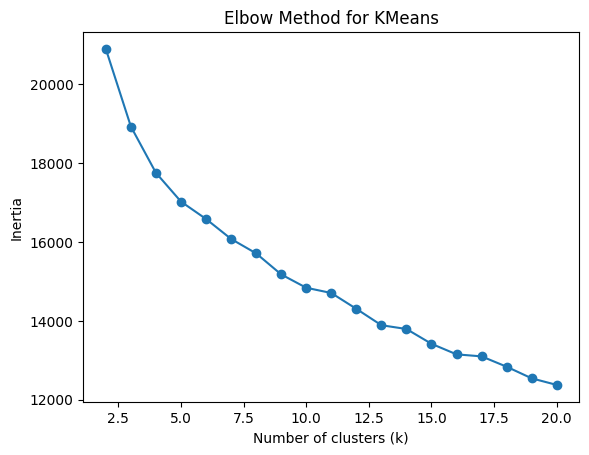

In [8]:
plt.plot(K_range, inertia_list, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')
plt.show()

In [9]:
k = 40
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_train_pca)


####  **STEP 5. 아래 `plot_faces` 함수를 이용하여, 클러스터를 시각화하고, 각 클러스터에 비슷한 얼굴이 들어있는지 확인해보세요.**

In [10]:
# plot_faces 함수
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

Cluster 0, 16 faces


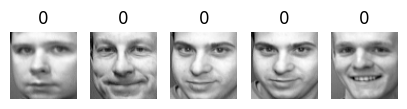

Cluster 1, 13 faces


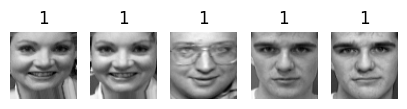

Cluster 2, 2 faces


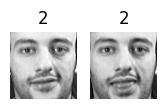

Cluster 3, 16 faces


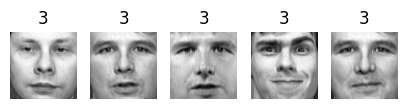

Cluster 4, 8 faces


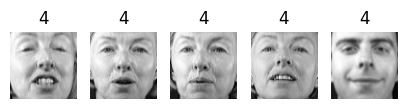

Cluster 5, 9 faces


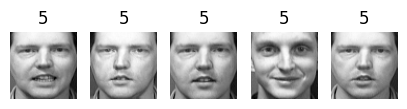

Cluster 6, 7 faces


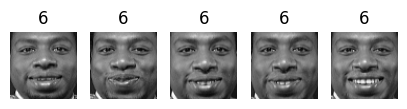

Cluster 7, 8 faces


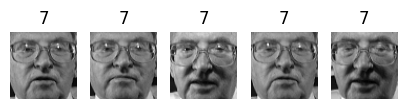

Cluster 8, 3 faces


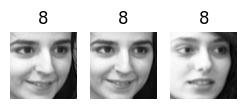

Cluster 9, 8 faces


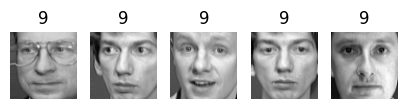

Cluster 10, 14 faces


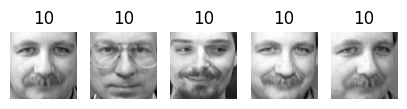

Cluster 11, 12 faces


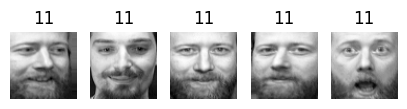

Cluster 12, 9 faces


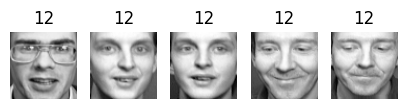

Cluster 13, 8 faces


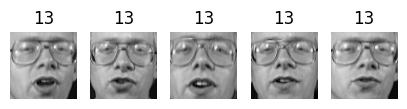

Cluster 14, 4 faces


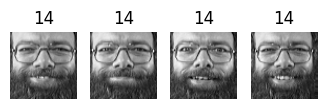

Cluster 15, 9 faces


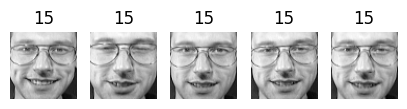

Cluster 16, 13 faces


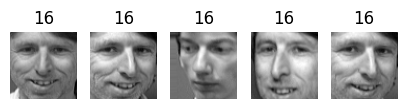

Cluster 17, 8 faces


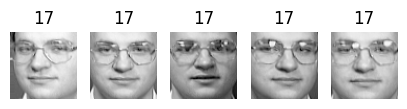

Cluster 18, 7 faces


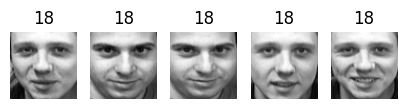

Cluster 19, 4 faces


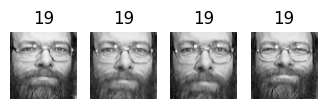

Cluster 20, 13 faces


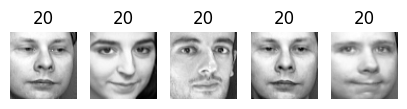

Cluster 21, 10 faces


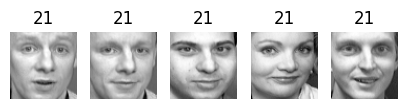

Cluster 22, 7 faces


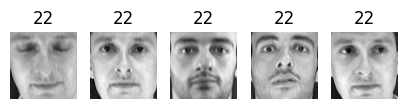

Cluster 23, 4 faces


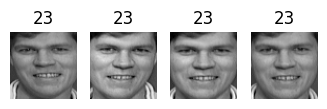

Cluster 24, 6 faces


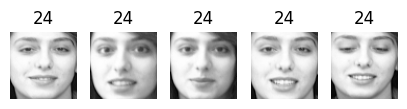

Cluster 25, 15 faces


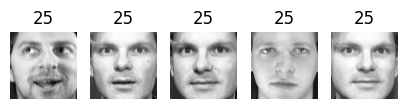

Cluster 26, 5 faces


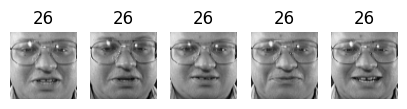

Cluster 27, 8 faces


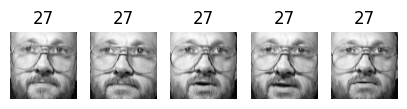

Cluster 28, 6 faces


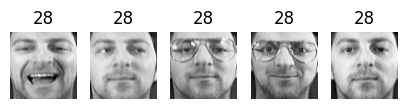

Cluster 29, 5 faces


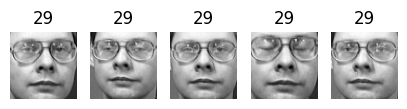

Cluster 30, 15 faces


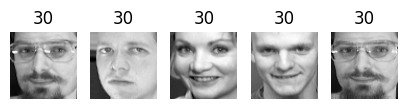

Cluster 31, 8 faces


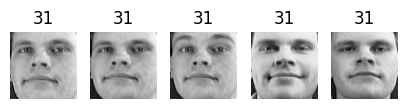

Cluster 32, 4 faces


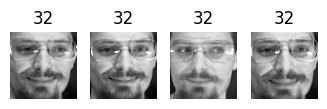

Cluster 33, 4 faces


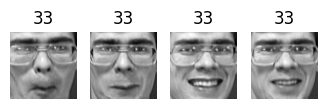

Cluster 34, 9 faces


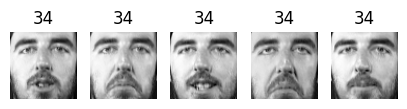

Cluster 35, 6 faces


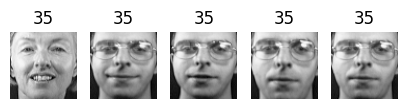

Cluster 36, 4 faces


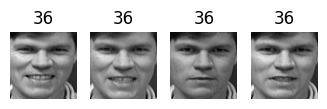

Cluster 37, 4 faces


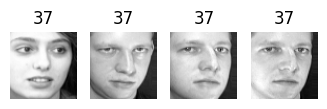

Cluster 38, 4 faces


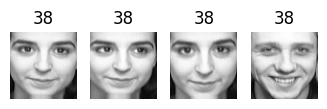

Cluster 39, 5 faces


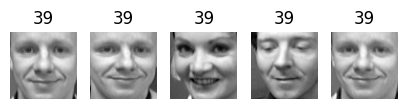

In [12]:
for cluster in range(k):
    cluster_faces = X_train[cluster_labels == cluster]
    cluster_labels_plot = cluster_labels[cluster_labels == cluster]
    if len(cluster_faces) > 0:
        print(f"Cluster {cluster}, {len(cluster_faces)} faces")
        plot_faces(cluster_faces[:5], cluster_labels_plot[:5])